# Clustering 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import torchvision.transforms as transforms
# from torchvision import datasets
import torch
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from Reconstruct import CNN
#import confusion_matrix as cm
import wandb_functions as wf

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [26]:
# Update plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10], #[15,7],#
})

In [4]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

# # Log into WandB
# wandb.login()

In [5]:
%%time
# define hyperparameters
params = {
  "dataset": "encoded_MNIST",
  "learning_rate": 1e-3,
  # "batch_size": 100,
  # "epochs": 20,
  # "kernel_size":23,
  "p": 23, # size of array (has to be prime)
  "image_size": 23,
  "kind": "tsne",
  "suffix": "encoded",
  # "lambda": 1e-7,
}
params['model'] = params['kind']+'_'+params['suffix']
# Compute MURA encoder and decoder
params['A'] = mura.create_binary_aperture_arr(params['p'])
params['G'] = mura.create_decoding_arr(params['A'])
# wandb.config = wf.wandb_config(params)

CPU times: user 1.36 ms, sys: 36 µs, total: 1.4 ms
Wall time: 1.39 ms


# Load data

In [6]:
%%time
# Load encoded data 
filename_train = "../data/training_MNIST_mura"
filename_eval  = "../data/validation_MNIST_mura"
filename_test  = "../data/testing_MNIST_mura"

mura_train_data = torch.load(filename_train)
mura_eval_data = torch.load(filename_eval)
mura_test_data = torch.load(filename_test)
print(f"Number of elements in each dataset \nTraining: {len(mura_train_data)} \nValidation: {len(mura_eval_data)} \nTesting: {len(mura_test_data)}")

Number of elements in each dataset 
Training: 56000 
Validation: 7000 
Testing: 7000
CPU times: user 5.09 s, sys: 2.39 s, total: 7.48 s
Wall time: 14.3 s


In [7]:
# Initialize lists to save data
og_data = []
encoded_data = []
labels = []

for i in range(len(mura_train_data)):
    # Need to flatten images to save into dataframe later
    og_data.append(mura_train_data[i][1].numpy().ravel())
    encoded_data.append(mura_train_data[i][0].numpy().ravel())
    labels.append(mura_train_data[i][2])
    
# Make dataframe for original data
og_df = pd.DataFrame(og_data)
#og_df["label"] = labels
og_df.head()

# Make dataframe for encoded data
encoded_df = pd.DataFrame(encoded_data)
#encoded_df["label"] = labels
encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,519,520,521,522,523,524,525,526,527,528
0,0.881420,0.865635,0.698443,0.377392,0.212761,0.198137,0.265131,0.374914,0.333275,0.389236,...,0.458789,0.465515,0.420620,0.454936,0.431120,0.267966,0.247600,0.419879,0.670975,0.880004
1,0.699587,0.691162,0.400407,0.356559,0.637285,0.571029,0.372613,0.456930,0.706062,0.605573,...,0.470645,0.669964,0.465438,0.341866,0.462192,0.356173,0.260749,0.367157,0.553703,0.731998
2,0.362370,0.167000,0.285000,0.486884,0.471144,0.297345,0.197813,0.395356,0.308628,0.284848,...,0.580357,0.577499,0.496104,0.637282,0.756652,0.441695,0.255308,0.361419,0.253362,0.462685
3,0.118450,0.396550,0.651631,0.806323,0.757734,0.490964,0.396758,0.482576,0.604117,0.538837,...,0.579733,0.645683,0.461248,0.441965,0.611055,0.883416,0.962086,0.710905,0.319325,0.008481
4,0.465111,0.302695,0.367303,0.408124,0.442953,0.411726,0.297214,0.351932,0.172961,0.199896,...,0.109760,0.503887,0.556509,0.244620,0.221364,0.345653,0.518305,0.717044,0.627376,0.567681


# Try T-SNE

In [9]:
from sklearn.manifold import TSNE

In [10]:
%%time
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(encoded_df)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 33min 26s, sys: 1min 27s, total: 34min 53s
Wall time: 6min 33s


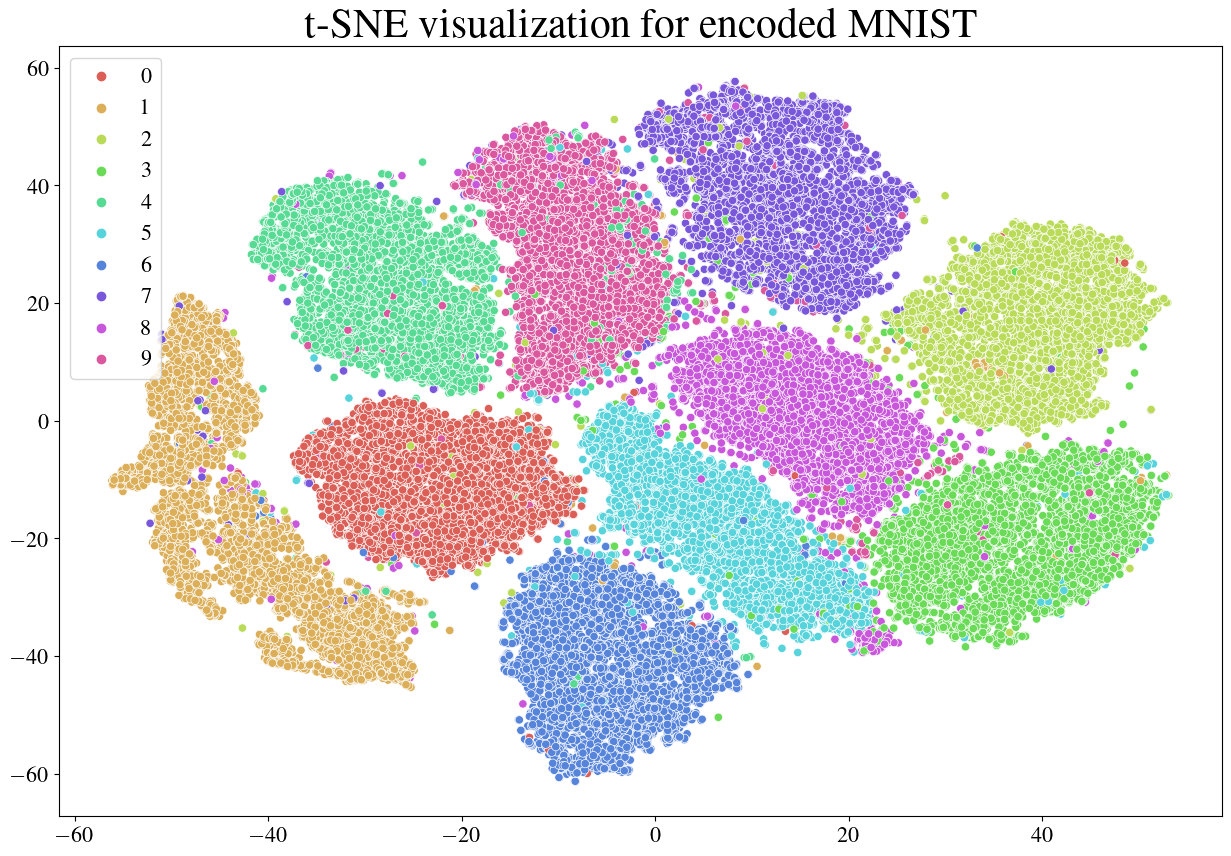

In [29]:
fontsize = 30
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = labels, palette = sns.hls_palette(10), legend = 'full')
plt.title("t-SNE visualization for encoded MNIST", fontsize=fontsize)
plt.xticks(fontsize=fontsize-14)
plt.yticks(fontsize=fontsize-14)
plt.legend(fontsize=fontsize-14)
#plt.savefig("../figs/tsne_encoded.png")
plt.show()

In [13]:
%%time
tsne = TSNE(n_components = 2, random_state=0)
tsne_og_data = tsne.fit_transform(og_df)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 32min 27s, sys: 1min 46s, total: 34min 14s
Wall time: 7min 5s


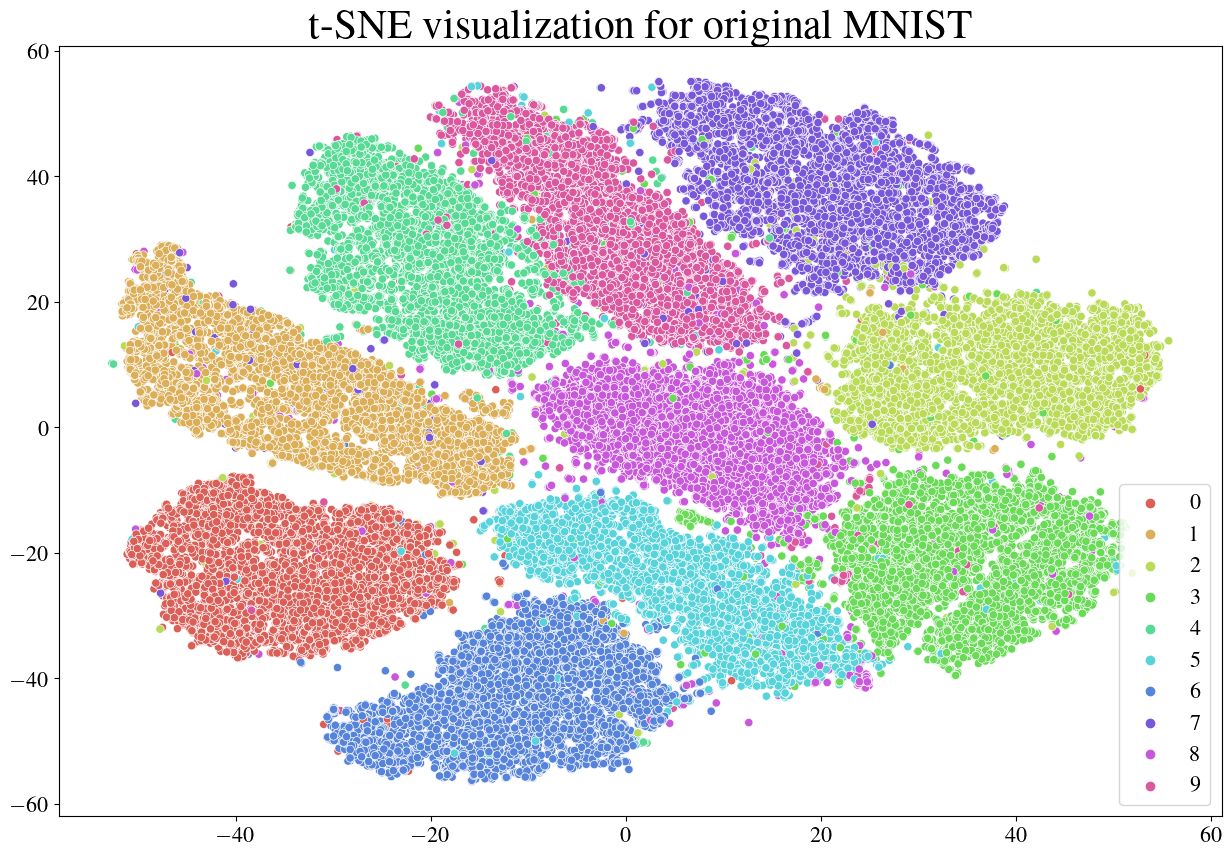

In [30]:
sns.scatterplot(x = tsne_og_data[:,0], y = tsne_og_data[:,1], hue = labels, palette = sns.hls_palette(10), legend = 'full');
plt.title("t-SNE visualization for original MNIST", fontsize=fontsize)
plt.xticks(fontsize=fontsize-14)
plt.yticks(fontsize=fontsize-14)
plt.legend(fontsize=fontsize-14)
#plt.savefig("../figs/tsne_original.png")
plt.show()

Do the $x$ and $y$ coordinates of each point matter? or just the distance relative to other clusters?